#Step 1: Pip Install and Import Libraries

##1a) Import Data Manipulation Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Install TALIB---------------------------------------------------------
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

!pip install Ta-Lib
import talib as ta

#Install Pyfolio------------------------------------------------------
!pip install pyfolio
import pyfolio as pf

#Install Yahoo Finance------------------------------------------------
!pip install yfinance
import yfinance as yf

<ipython-input-1-40d2ad1fe28d>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


--2023-07-20 05:31:34--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-20 05:31:34--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-20 05:31:34--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.s

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(




---



#Step 2: Import Dataset & Plot

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2022-01-03,32.790001
2022-01-04,33.709999
2022-01-05,33.240002
2022-01-06,33.820000
2022-01-07,34.369999
...,...
2023-07-14,31.990000
2023-07-17,32.470001
2023-07-18,32.529999


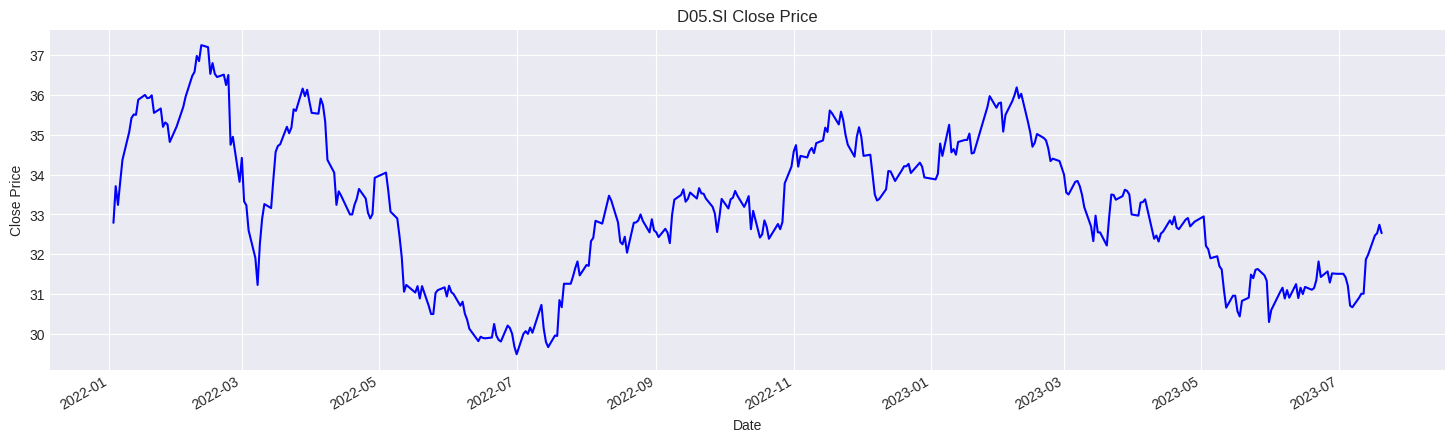

In [2]:
ticker = 'D05.SI'
data = yf.download(ticker,start='2022-01-01')

#we only want the Close price
data = pd.DataFrame(data['Close'])
display(data)

#Plot---------------------------------------
data.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()



---



#Step 3: Create a Function to Define Features and Target

Mission:
- we are trying to define X to predict y
- y is the Stock Close Price
- X will contain arbitary features defined by us that we believe can be used as indicators to predict y  
- later on, we will use X and y to train the Logistic Regression Model to assist with the prediction

In [3]:
def get_target_features(data):

    # -------------------------------------------------------------
    # Define Features (X)
    #Volatility
    #(we use the pct_change() to get the Volatility)
    data['PCT_CHANGE'] = data['Close'].pct_change()
    data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100

    #Correlation
    #(we use the SMA to get the CORR)
    data['SMA'] = ta.SMA(data['Close'],14)
    data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)

    #RSI (unused)
    #data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)

    #ADX (unused)
    #data['ADX'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)


    # ------------------------------------------------------------
    # Define Target (y)
    data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)

    # Create the signal column
    data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)

    data = data.dropna()

    return data['Actual_Signal'], data[['VOLATILITY', 'CORR']]


##Features, X: Volatility & Correlation

###1) PCT_CHANGE(): (we use it to get Volatility)
- (current value — previous value) / previous value * 100
- Basically, it tells us how today is performing compared to yesterday.
- "if u had bought YESETERDAY, this would have been your returns TODAY..."

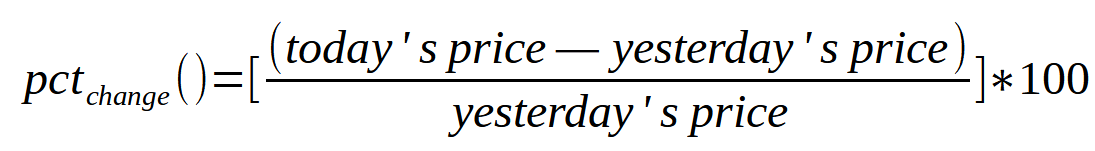

,Close,PCT_CHANGE
Date,,
2022-01-03,32.790001,NaN
2022-01-04,33.709999,0.028057
2022-01-05,33.240002,-0.013942
2022-01-06,33.820000,0.017449
2022-01-07,34.369999,0.016263
...,...,...
2023-07-14,31.990000,0.003765
2023-07-17,32.470001,0.015005
2023-07-18,32.529999,0.001848


<Axes: xlabel='Date'>

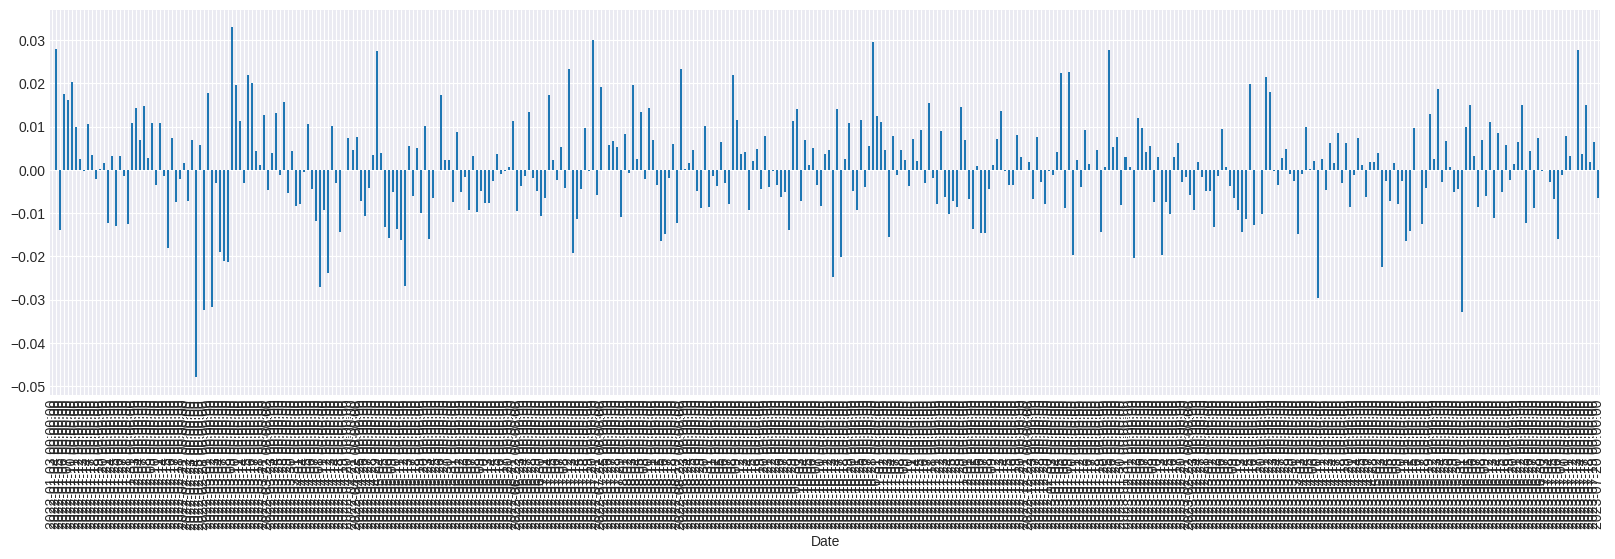

In [4]:
data['PCT_CHANGE'] = data['Close'].pct_change()
display(data)
#notice a new column "pct_change" has been created

data['PCT_CHANGE'].plot(kind='bar', figsize=(20,5))



---



###2) Volatility

- Volatility is measured by the standard deviation of the asset over a given period of time.
- The higher the standard deviation, the higher the volatility.

- In general, a volatility of 10% or less is considered to be low
- A volatility of 20% or more is considered to be high.

,Close,PCT_CHANGE,VOLATILITY
Date,,,
2022-01-03,32.790001,NaN,NaN
2022-01-04,33.709999,0.028057,NaN
2022-01-05,33.240002,-0.013942,NaN
2022-01-06,33.820000,0.017449,NaN
2022-01-07,34.369999,0.016263,NaN
...,...,...,...
2023-07-14,31.990000,0.003765,0.998020
2023-07-17,32.470001,0.015005,1.061423
2023-07-18,32.529999,0.001848,1.014116


<Axes: xlabel='Date'>

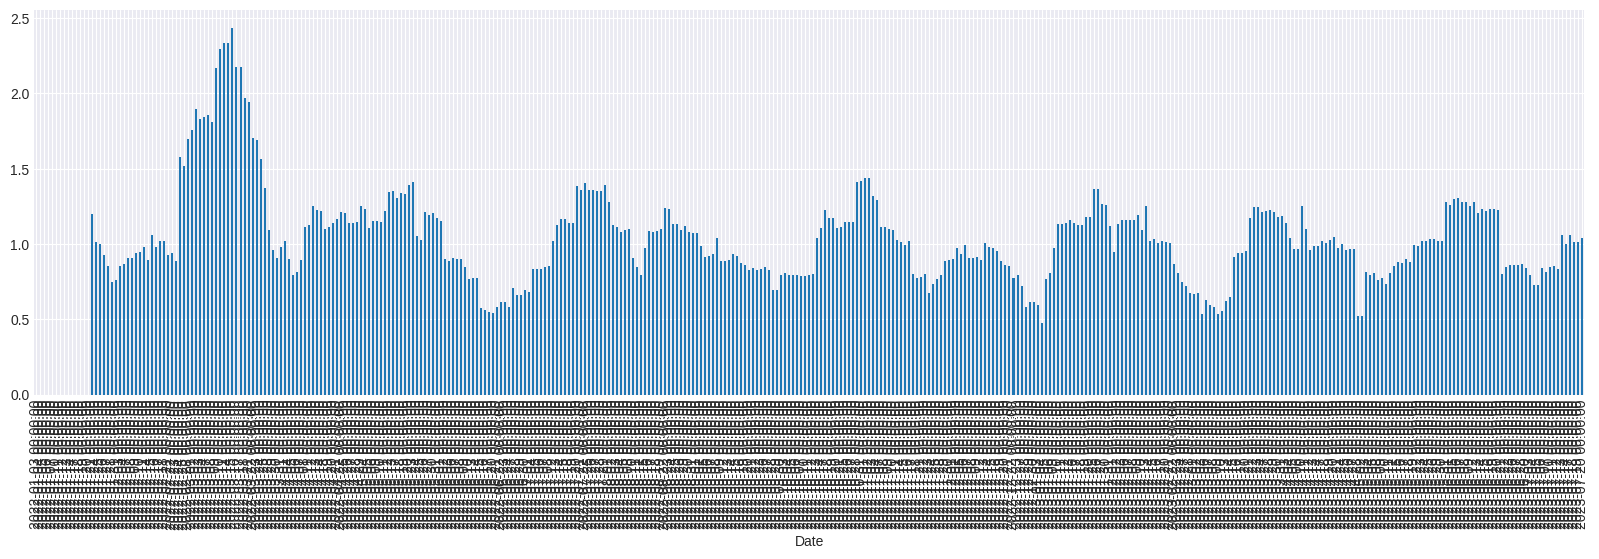

In [5]:
data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100
display(data)
#notice a new column "volatility" has been created

data['VOLATILITY'].plot(kind='bar', figsize=(20,5))
#perhaps we should only buy when there's great volatility?



---



###3) SMA (we use the SMA to get the Corr)

How does SMA work?

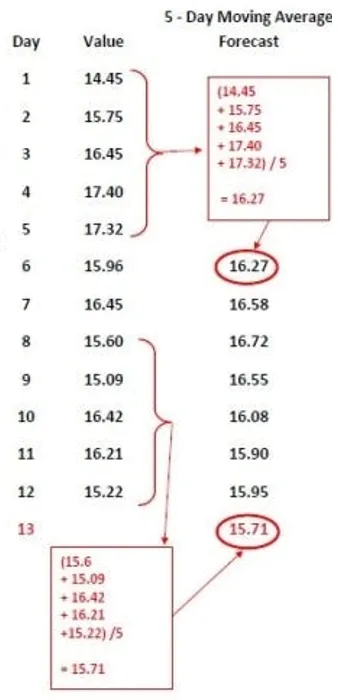

,Close,PCT_CHANGE,VOLATILITY,SMA
Date,,,,
2022-01-03,32.790001,NaN,NaN,NaN
2022-01-04,33.709999,0.028057,NaN,NaN
2022-01-05,33.240002,-0.013942,NaN,NaN
2022-01-06,33.820000,0.017449,NaN,NaN
2022-01-07,34.369999,0.016263,NaN,NaN
...,...,...,...,...
2023-07-14,31.990000,0.003765,0.998020,31.300000
2023-07-17,32.470001,0.015005,1.061423,31.364286
2023-07-18,32.529999,0.001848,1.014116,31.452857


<Axes: xlabel='Date'>

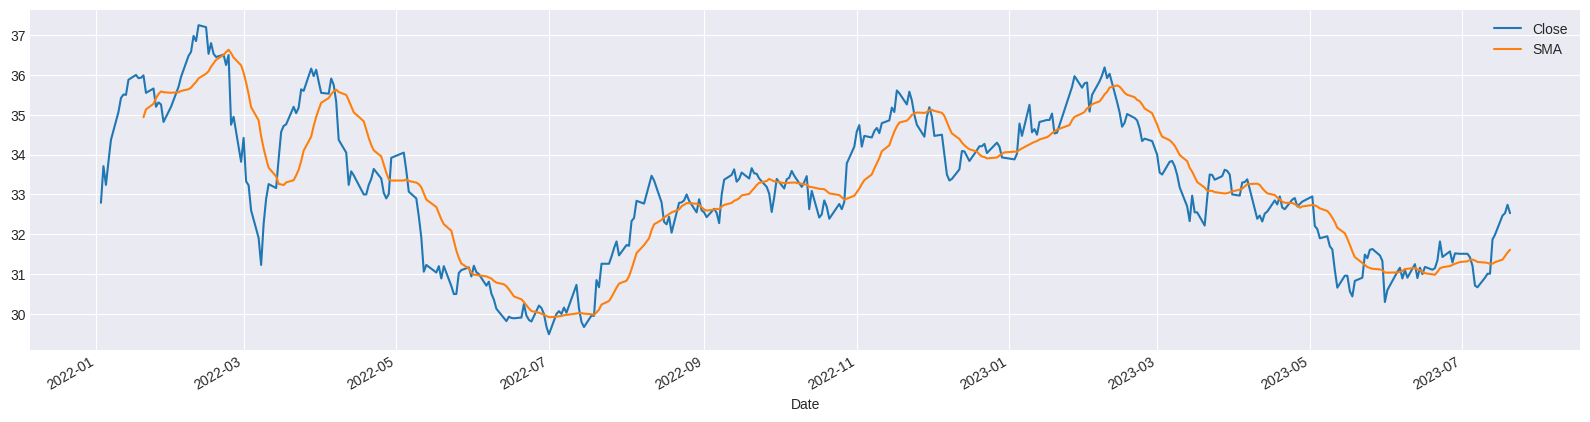

In [6]:
data['SMA'] = ta.SMA(data['Close'],14)
display(data)


data[['Close', 'SMA']].plot(figsize=(20,5))



---



###4) Correlation

- Correlation coefficient is between -1 and 1.
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation.

- The corr function calculates the correlation between 'Close' and 'SMA' over a window of 14 days.

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR
Date,,,,,
2022-01-03,32.790001,NaN,NaN,NaN,NaN
2022-01-04,33.709999,0.028057,NaN,NaN,NaN
2022-01-05,33.240002,-0.013942,NaN,NaN,NaN
2022-01-06,33.820000,0.017449,NaN,NaN,NaN
2022-01-07,34.369999,0.016263,NaN,NaN,NaN
...,...,...,...,...,...
2023-07-14,31.990000,0.003765,0.998020,31.300000,-0.232024
2023-07-17,32.470001,0.015005,1.061423,31.364286,0.151744
2023-07-18,32.529999,0.001848,1.014116,31.452857,0.464025


<Axes: xlabel='Date'>

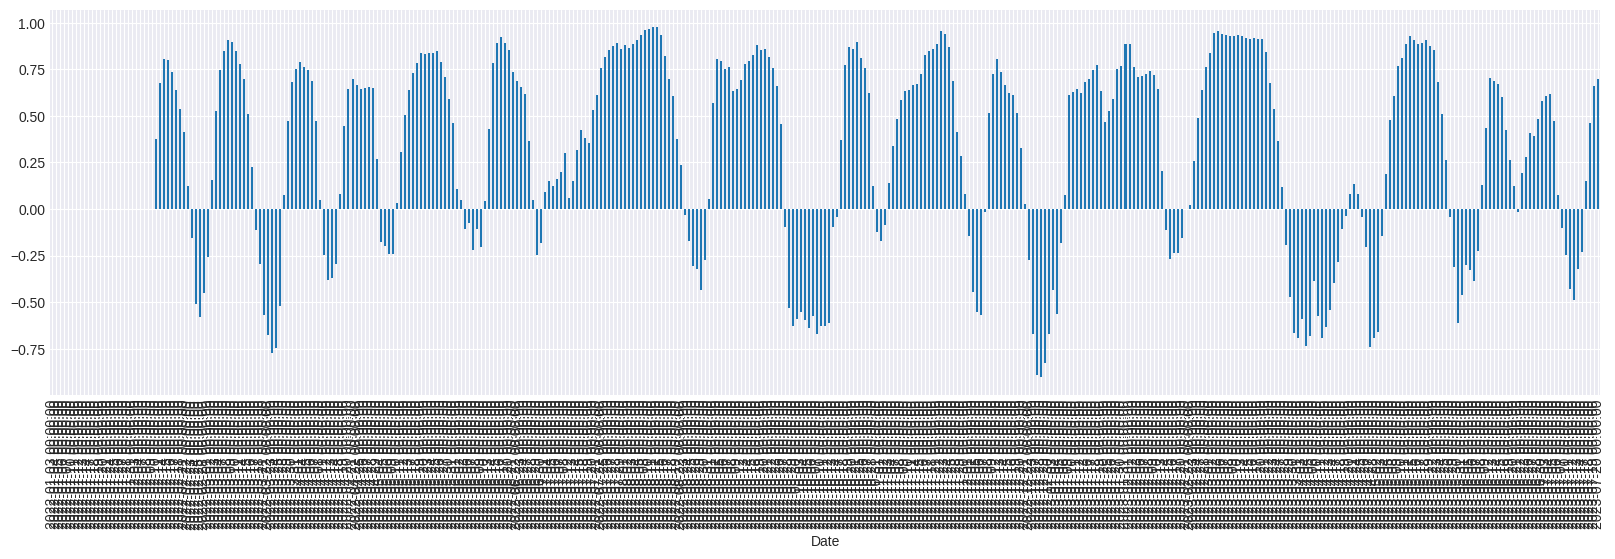

In [7]:
data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)
display(data)

data['CORR'].plot(kind='bar', figsize=(20,5))

#SMA and the Close price is supposed to move together,
#but u can see that sometimes it doesn't.
#perhaps when there's -ve correlation, we shouldn't buy?



---



##Target, y: Returns for Tomorrow & Signal

###1) Returns 4 Tmrw

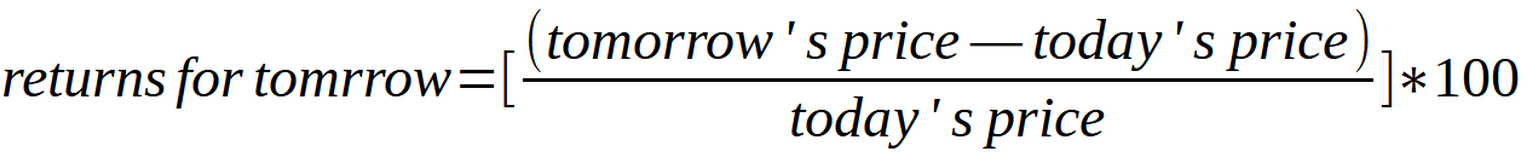

- "if you buy TODAY, this will be your returns for TOMORROW"
- we use the 'Returns 4 Tomorrow' to determine whether is GOOD or NO GOOD.
- If the Returns is positive, its GOOD.
- If the Returns is Negative, its BAD.
- in other words, we are going to use the Returns as a labelled indicator to train the model (to predict whether to buy or not).


,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,Returns_4_Tmrw
Date,,,,,,
2022-01-03,32.790001,NaN,NaN,NaN,NaN,0.028057
2022-01-04,33.709999,0.028057,NaN,NaN,NaN,-0.013942
2022-01-05,33.240002,-0.013942,NaN,NaN,NaN,0.017449
2022-01-06,33.820000,0.017449,NaN,NaN,NaN,0.016263
2022-01-07,34.369999,0.016263,NaN,NaN,NaN,0.020367
...,...,...,...,...,...,...
2023-07-14,31.990000,0.003765,0.998020,31.300000,-0.232024,0.015005
2023-07-17,32.470001,0.015005,1.061423,31.364286,0.151744,0.001848
2023-07-18,32.529999,0.001848,1.014116,31.452857,0.464025,0.006456


<Axes: xlabel='Date'>

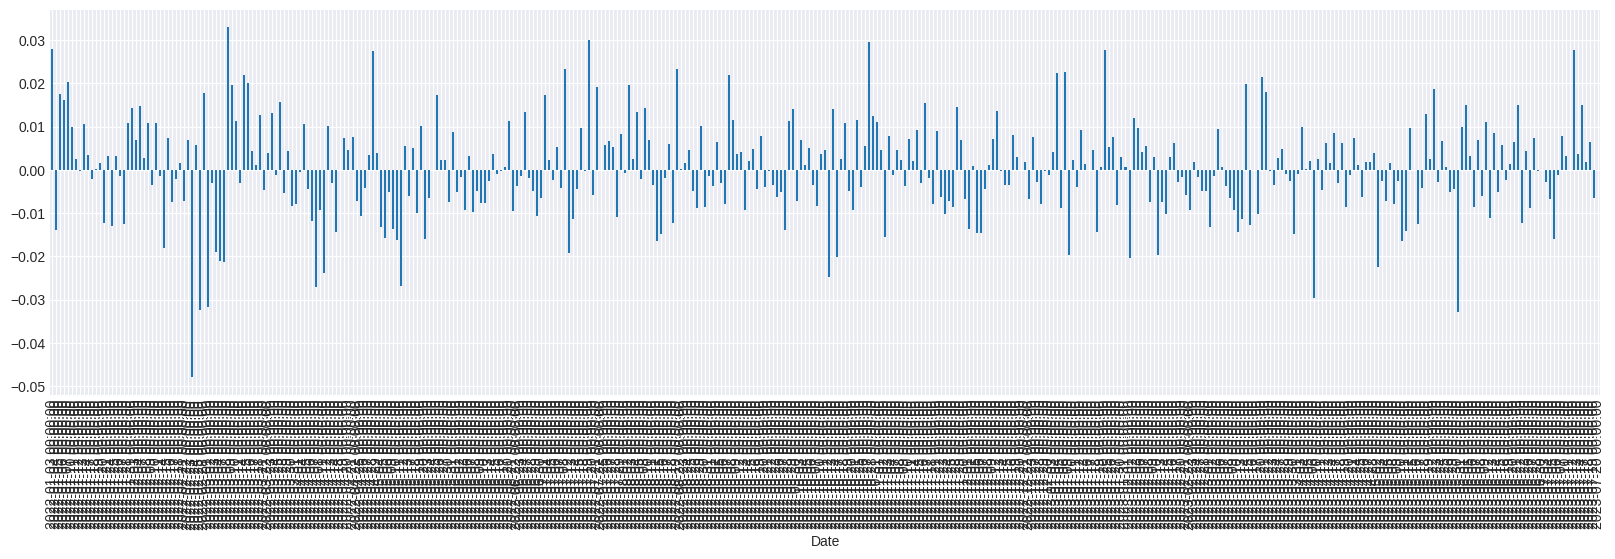

In [8]:
# Define Target (y)
data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)
display(data)
#notice a new column 'Returns_4_Tmrw' has been created

data['Returns_4_Tmrw'].plot(kind='bar', figsize=(20,5))



---



###2) Creating the Signal

##np.where()
- If data['Returns_4_Tmrw'] > 0, then Signal will turn 1, else 0.
- 1: Means GOOD = BUY.
- 0: Means BAD = Don't BUY.
- in other words, the Returns column is the "labelled data" used for training

In [9]:
data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)
display(data)

#notice a new column 'signal' has been created
#1 means BUY for that day
#0 means DON'T BUY for that day

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,Returns_4_Tmrw,Actual_Signal
Date,,,,,,,
2022-01-03,32.790001,NaN,NaN,NaN,NaN,0.028057,1
2022-01-04,33.709999,0.028057,NaN,NaN,NaN,-0.013942,0
2022-01-05,33.240002,-0.013942,NaN,NaN,NaN,0.017449,1
2022-01-06,33.820000,0.017449,NaN,NaN,NaN,0.016263,1
2022-01-07,34.369999,0.016263,NaN,NaN,NaN,0.020367,1
...,...,...,...,...,...,...,...
2023-07-14,31.990000,0.003765,0.998020,31.300000,-0.232024,0.015005,1
2023-07-17,32.470001,0.015005,1.061423,31.364286,0.151744,0.001848,1
2023-07-18,32.529999,0.001848,1.014116,31.452857,0.464025,0.006456,1




---



#Step 4: Train Test Split

##4a) Display y and X

In [10]:
y, X = get_target_features(data)

In [11]:
y.head()

Date
2022-02-10    1
2022-02-11    0
2022-02-14    0
2022-02-15    1
2022-02-16    0
Name: Actual_Signal, dtype: int64

In [12]:
X.head()

,VOLATILITY,CORR
Date,,
2022-02-10,0.950517,0.377809
2022-02-11,0.980410,0.678399
2022-02-14,0.893955,0.803478
2022-02-15,1.059925,0.797975
2022-02-16,0.979500,0.737916


##4b) Split 80% for Training and 20% for Testing

In [13]:
split = int(0.8*len(X))
#80% of the total number of rows

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
#X[:split] means from row 0 to row number 'split'
#X[split:] means from row 'split' until the last row



---



#Step 5: Use StandardScaler() to Scale the X

##5a) Import the StandardScaler()

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##5b) Scale X_train and X_test

In [15]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**sc.fit_transform(X_train): **
- The scaling parameters are learned from the training data and are stored in the scaler object.

**sc.transform(X_test): **
- This method transforms the test data using the scaling parameters that were learned from the training data.
- The test data is not scaled again, because this would introduce noise into the data.

**In general, **
- Use **sc.fit_transform(X_train)** on the training data and then use **sc.transform(X_test)** on the test data.

- This will ensure that the training and test data are scaled in the same way and that the model makes accurate predictions on the test data.



---



#Step 6: Import Logistic Regression Model and Start Training

##6a) Importing and Training

In [16]:
model = LogisticRegression()
model = model.fit(X_train,y_train)

##6b) Predicting y_pred

In [17]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

##6c) Showing the Probabilities for 0 and 1

In [18]:
probability = model.predict_proba(X_test)
print(probability)

[[0.61405487 0.38594513]
 [0.60107147 0.39892853]
 [0.53761434 0.46238566]
 [0.58148067 0.41851933]
 [0.6138238  0.3861762 ]
 [0.60303077 0.39696923]
 [0.59573905 0.40426095]
 [0.58247643 0.41752357]
 [0.57791673 0.42208327]
 [0.5691519  0.4308481 ]
 [0.55937588 0.44062412]
 [0.5748086  0.4251914 ]
 [0.57127336 0.42872664]
 [0.58766575 0.41233425]
 [0.5921844  0.4078156 ]
 [0.6165082  0.3834918 ]
 [0.71669488 0.28330512]
 [0.71438632 0.28561368]
 [0.62812997 0.37187003]
 [0.61824964 0.38175036]
 [0.60199749 0.39800251]
 [0.60769065 0.39230935]
 [0.59655434 0.40344566]
 [0.60427713 0.39572287]
 [0.58256807 0.41743193]
 [0.56925347 0.43074653]
 [0.56321348 0.43678652]
 [0.56560734 0.43439266]
 [0.55843207 0.44156793]
 [0.56288413 0.43711587]
 [0.53629016 0.46370984]
 [0.53939317 0.46060683]
 [0.53788215 0.46211785]
 [0.54585072 0.45414928]
 [0.55480635 0.44519365]
 [0.5693307  0.4306693 ]
 [0.58483116 0.41516884]
 [0.59716072 0.40283928]
 [0.52496081 0.47503919]
 [0.52175763 0.47824237]




---



#Step 7: Confusion Matrix and Accuracy Metric

In [19]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('\n\n\n',metrics.classification_report(y_test, predicted))


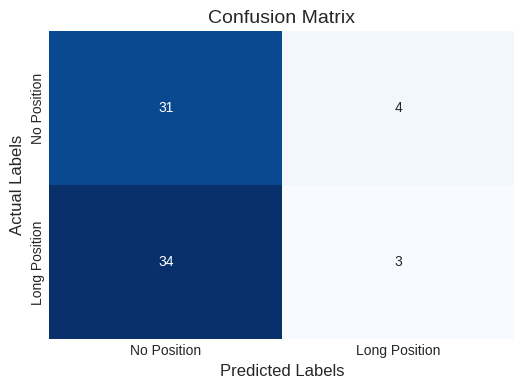




               precision    recall  f1-score   support

           0       0.48      0.89      0.62        35
           1       0.43      0.08      0.14        37

    accuracy                           0.47        72
   macro avg       0.45      0.48      0.38        72
weighted avg       0.45      0.47      0.37        72



In [20]:
get_metrics(y_test, y_pred)

In [21]:
#if the Accuracy (placed below the f1-score) is low... try
#1) putting in more metrics like SMA and Corr
#2) shortening the time period of testing
#3) change the ML model?



---



#Step 8: Backtesting Our Model

##8a) Obtaining our Backtest Data

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2016-01-04,16.280001
2016-01-05,16.240000
2016-01-06,16.100000
2016-01-07,15.700000
2016-01-08,15.720000
...,...
2016-12-23,17.389999
2016-12-27,17.440001
2016-12-28,17.469999


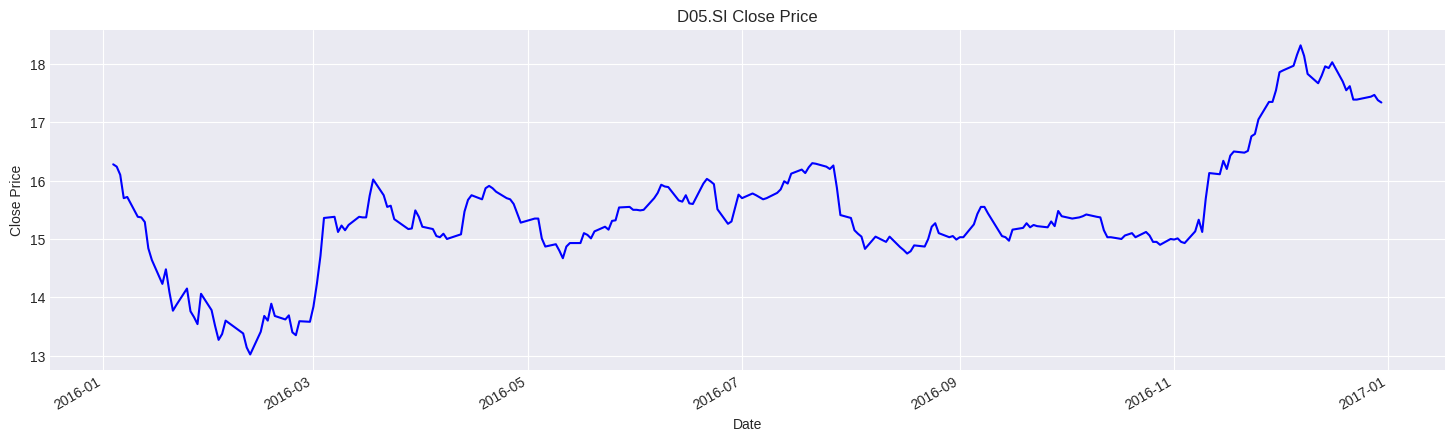

In [22]:
ticker = 'D05.SI'
df = yf.download(ticker,start='2016-01-01', end='2017-01-01')
#we change the dates
#and is no longer called "data" but "df"

#we only want the Close price
df = pd.DataFrame(df['Close'])
display(df)

#Plot---------------------------------------
df.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()

##8b) Creating the Volatility and Correlation Columns as Features

In [23]:
#Create Volatility-----------------------------------------------
df['PCT_CHANGE'] = df['Close'].pct_change()
df['VOLATILITY'] = df.rolling(14)['PCT_CHANGE'].std()*100

#Create Correlation----------------------------------------------
df['SMA'] = ta.SMA(df['Close'],14)
df['CORR'] = ta.CORREL(df['Close'], df['SMA'], 14)

df = df.dropna()

#Create a temp_df to slice out only Volatility and Correlation
#temp_df = df[['VOLATILITY','CORR']]

display(df)

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR
Date,,,,,
2016-02-11,13.140000,-0.017937,1.971153,13.632857,0.727183
2016-02-12,13.020000,-0.009132,1.908627,13.579286,0.805925
2016-02-15,13.410000,0.029954,2.097066,13.546429,0.799983
2016-02-16,13.680000,0.020134,2.096629,13.512857,0.604676
2016-02-17,13.600000,-0.005848,1.971203,13.501429,0.502829
...,...,...,...,...,...
2016-12-23,17.389999,0.000000,1.017874,17.820714,-0.692272
2016-12-27,17.440001,0.002875,0.962303,17.769286,-0.629114
2016-12-28,17.469999,0.001720,0.913687,17.708571,-0.382355


##8c) Scale and Predict

In [24]:
df_scaled = sc.transform(df[['VOLATILITY','CORR']])

In [25]:
#Create a New Column
df['predicted_signal_4_tmrw'] = model.predict(df_scaled)

display(df)

<ipython-input-25-0207eee7556a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_signal_4_tmrw'] = model.predict(df_scaled)


,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,predicted_signal_4_tmrw
Date,,,,,,
2016-02-11,13.140000,-0.017937,1.971153,13.632857,0.727183,1
2016-02-12,13.020000,-0.009132,1.908627,13.579286,0.805925,1
2016-02-15,13.410000,0.029954,2.097066,13.546429,0.799983,1
2016-02-16,13.680000,0.020134,2.096629,13.512857,0.604676,1
2016-02-17,13.600000,-0.005848,1.971203,13.501429,0.502829,1
...,...,...,...,...,...,...
2016-12-23,17.389999,0.000000,1.017874,17.820714,-0.692272,0
2016-12-27,17.440001,0.002875,0.962303,17.769286,-0.629114,0
2016-12-28,17.469999,0.001720,0.913687,17.708571,-0.382355,0


##8d) Create the Buying Strategy

- Prediction is for the next day (based on features given for today).
- If we predict a 0 for tomorrow, we don't buy and have 0 Returns.
- **if we predict a 1 for tomorrow, we buy and we expect a Returns of 1 x tomorrow's PCT_CHANGE **

In [26]:
# Calculate the Next Day's strategy returns
df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']

# Drop the missing values
df.dropna(inplace=True)

display(df)

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,predicted_signal_4_tmrw,strategy_returns
Date,,,,,,,
2016-02-12,13.020000,-0.009132,1.908627,13.579286,0.805925,1,-0.009132
2016-02-15,13.410000,0.029954,2.097066,13.546429,0.799983,1,0.029954
2016-02-16,13.680000,0.020134,2.096629,13.512857,0.604676,1,0.020134
2016-02-17,13.600000,-0.005848,1.971203,13.501429,0.502829,1,-0.005848
2016-02-18,13.890000,0.021324,2.044194,13.517857,0.332806,1,0.021324
...,...,...,...,...,...,...,...
2016-12-23,17.389999,0.000000,1.017874,17.820714,-0.692272,0,0.000000
2016-12-27,17.440001,0.002875,0.962303,17.769286,-0.629114,0,0.000000
2016-12-28,17.469999,0.001720,0.913687,17.708571,-0.382355,0,0.000000


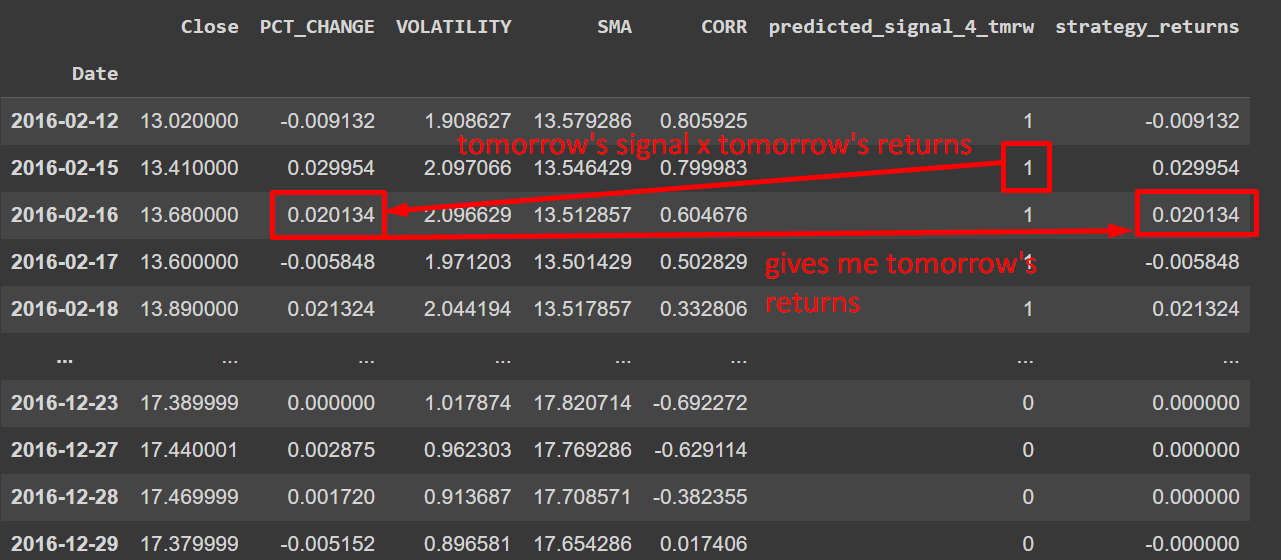

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2016-02-12
End date,2016-12-30
Total months,10
,Backtest
Annual return,25.5%
Cumulative returns,22.5%
Annual volatility,11.0%
Sharpe ratio,2.11
Calmar ratio,3.27
Stability,0.25
Max drawdown,-7.8%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


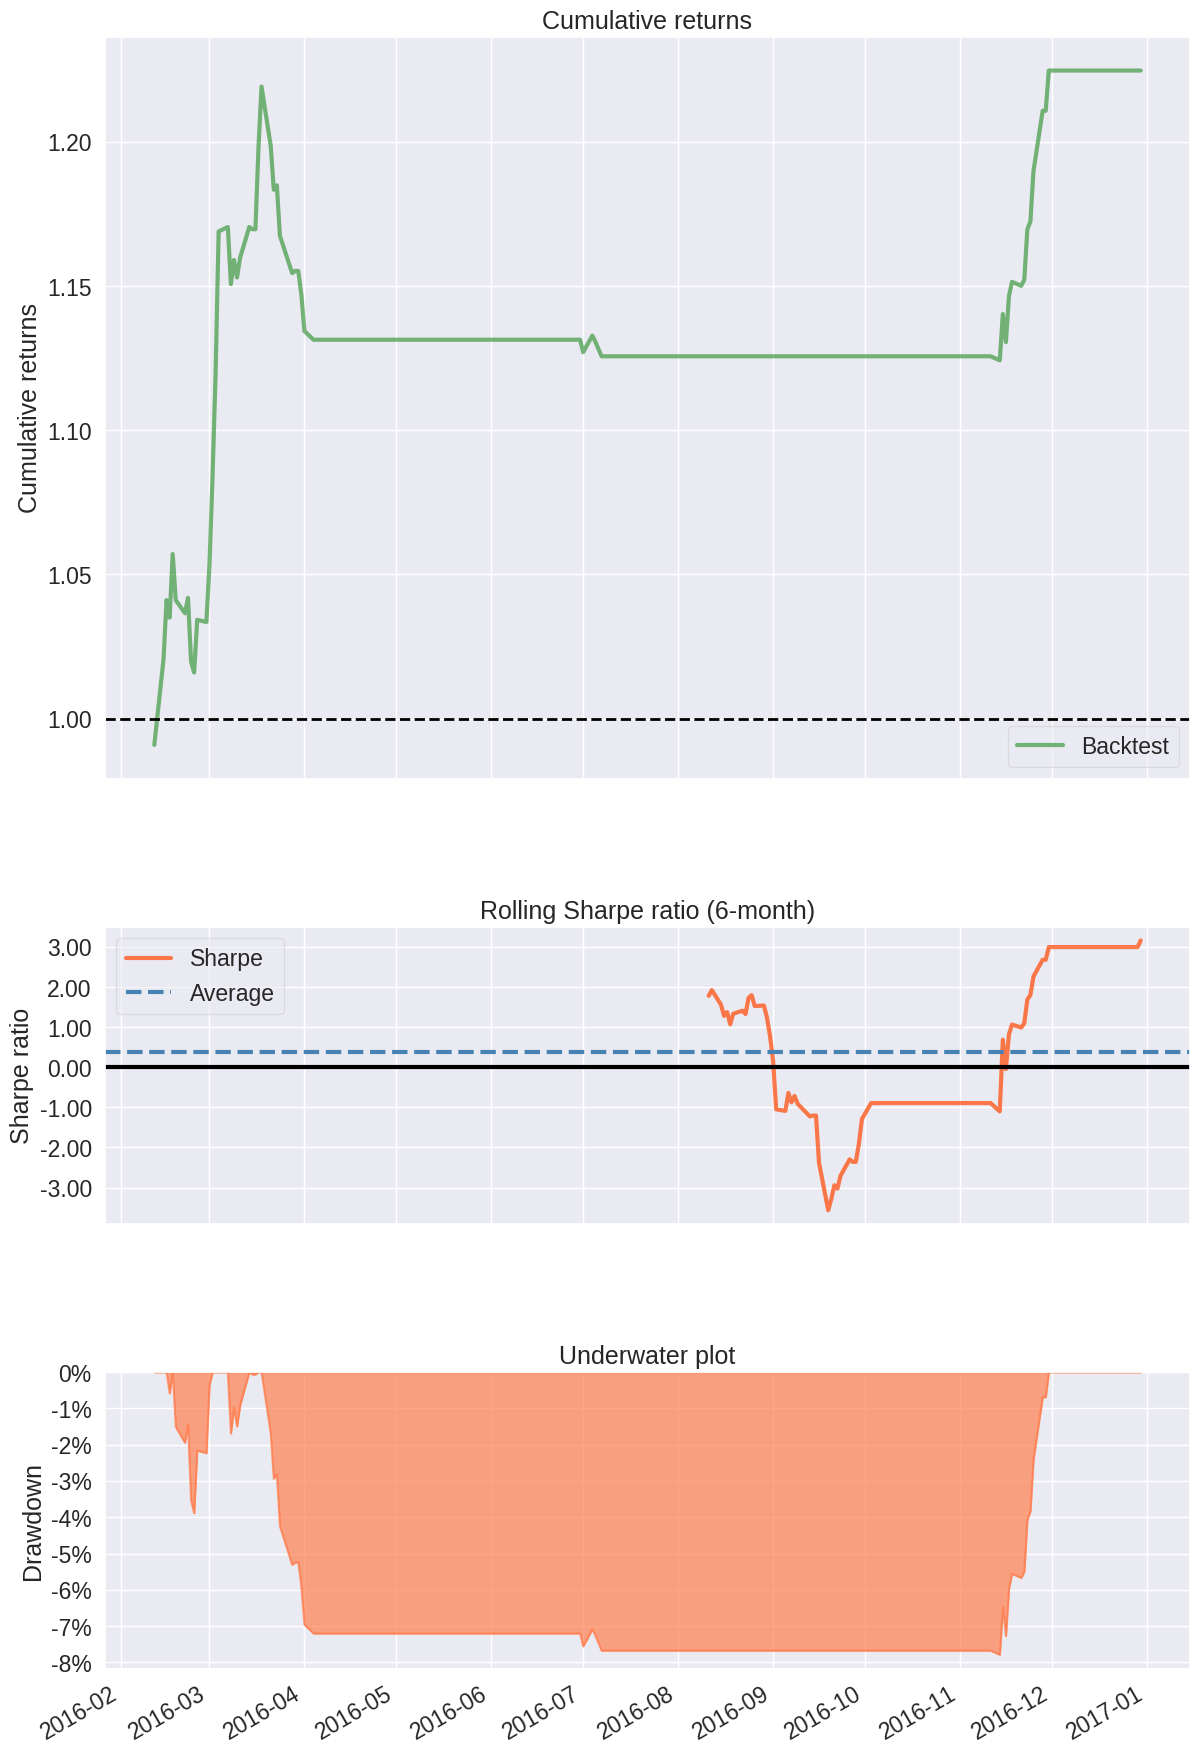

In [27]:
pf.create_simple_tear_sheet(df['strategy_returns'])



---

#THE END



---

